In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [60]:
class DecisionStump:
    def __init__(self):
        self.threshold_ = None
        self.feature_index_ = None
        self.polarity_ = None

    def fit(self, X, y, w):
        m, n = X.shape
        best_score = float('inf')
        for feature_idx in range(n):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                for polarity in [1, -1]:
                    y_pred = np.ones(m)
                    y_pred[polarity * feature_values < polarity * threshold] = -1
                    score = np.sum(w * (y_pred != y))
                    if score < best_score:
                        self.threshold_ = threshold
                        self.feature_index_ = feature_idx
                        self.polarity_ = polarity
                        best_score = score

    def predict(self, X):
        m, n = X.shape
        y_pred = np.ones(m)
        feature_values = X[:, self.feature_index_]
        y_pred[self.polarity_ * feature_values < self.polarity_ * self.threshold_] = -1
        return y_pred

In [61]:
class AdaBoost:
    def __init__(self, n_classifiers):
        self.n_classifiers_ = n_classifiers
        self.alpha_ = np.zeros(n_classifiers)
        self.classifiers_ = []

    def fit(self, X, y):
        m, n = X.shape
        w = np.full(m, 1/m)
        for i in range(self.n_classifiers_):
            clf = DecisionStump()
            clf.fit(X, y, w)
            y_pred = clf.predict(X)
            error = np.sum(w * (y_pred != y))
            self.alpha_[i] = 0.5 * np.log((1 - error) / error)
            w = w * np.exp(-self.alpha_[i] * y * y_pred)
            w = w / np.sum(w)
            self.classifiers_.append(clf)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_classifiers_):
            y_pred += self.alpha_[i] * self.classifiers_[i].predict(X)
        return np.sign(y_pred)

    def performance_measure(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1,)
        labels = np.unique(y_test)
        n_labels = len(labels)
        conf_mat = [[0 for _ in range(n_labels)] for _ in range(n_labels)]
        for i in range(n_labels):
            for j in range(n_labels):
                conf_mat[i][j] = np.sum((y_test == labels[i]) & (y_pred == labels[j]))
        values = np.array(conf_mat)
        fig, ax = plt.subplots()
        ax.matshow(values)
        for (i, j), z in np.ndenumerate(values):
            ax.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        true_pred = np.trace(values)
        accuracy = true_pred / np.sum(values)
        print("Accuracy: ", accuracy)
        precision = [0 for _ in range(n_labels)]
        recall = [0 for _ in range(n_labels)]
        f1_score = [0 for _ in range(n_labels)]
        print("Precision:")
        for j in range(n_labels):
            true_positive = values[j, j]
            precision[j] = true_positive / np.sum(values[:, j])
            print("\tClass -", labels[j], ":", precision[j])
        print("Recall:")
        for i in range(n_labels):
            true_positive = values[i, i]
            recall[i] = true_positive / np.sum(values[i, :])
            print("\tClass -", labels[i], ":", recall[i])
        print("F1-Score:")
        for i in range(n_labels):
            f1_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
            print("\tClass -", labels[i], ":", f1_score[i])

In [62]:
def train_test_split(X, y, test_size=None, train_size=None):
    if test_size is None and train_size is None:
        test_size = 0.25
    if train_size is None:
        train_size = 1 - test_size
    arr_rand = np.random.rand(len(X))
    mask = arr_rand < np.percentile(arr_rand, int(train_size * 100))
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    return X_train, X_test, y_train, y_test

In [63]:
X, y = load_breast_cancer(return_X_y=True)

In [64]:
X[:5]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [65]:
y[y == 0] = -1

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

In [67]:
ada = AdaBoost(n_classifiers=15)
ada.fit(X_train, y_train)

Accuracy:  0.965034965034965
Precision:
	Class - -1 : 0.9482758620689655
	Class - 1 : 0.9764705882352941
Recall:
	Class - -1 : 0.9649122807017544
	Class - 1 : 0.9651162790697675
F1-Score:
	Class - -1 : 0.9565217391304347
	Class - 1 : 0.9707602339181286


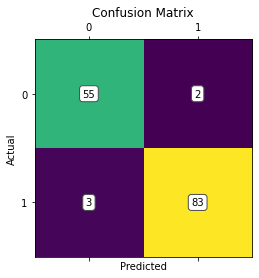

In [68]:
ada.performance_measure(X_test, y_test)